In [1]:

import sys
sys.path.append('..')
from src.evo_eq_model import *

In [2]:
import random
import numpy.random as rnd
import networkx as nx
from anytree import Node
from tqdm import tqdm
import numpy as np
import os
import sys
from jupyter_server import serverapp as app; 
import ipykernel, requests;
if(sys.version_info[1]<= 7):
    import pickle5 as pickle
else:
    import pickle
    
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter
fmt = lambda x, pos: '{:.3f}'.format(x)
from numba import jit

#matplotlib.use('TkAgg')
from matplotlib.lines import Line2D
plt.rc('mathtext', default='regular')

sns.set(context='poster')
sns.set_style("white")
plt.rc('lines', linewidth=3.0)
plt.rcParams['xtick.labelsize']=30
plt.rcParams['ytick.labelsize']=30
plt.rcParams['axes.labelsize']=35
plt.rcParams['legend.fontsize']= 25
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['image.cmap']='coolwarm'
plt.rcParams['axes.titlesize'] = 40
plt.rcParams['figure.titlesize'] = 40

In [3]:
def model(X, t, R0, kappa):
        x = X[0]
        y = X[1]
        z = X[2]
        dxdt = - R0/(1+kappa * y) *x * y
        dydt =  R0/(1+kappa* y) * x * y - y
        dzdt = y
        return [dxdt, dydt, dzdt]


In [4]:
import pandas as pd
import scipy.interpolate as spi



In [5]:
@jit(nopython=True)    
def find_t_intersection(f,g, t):
    #print(np.sign(f - g))
    idx = np.argwhere(np.diff(np.sign(f - g))).flatten()
    #print(idx)
    if len(idx)>0:
        return t[idx[0]]
    else:
        return np.inf

@jit(nopython=True)    
def find_ind_intersection(f,g):
    #print(np.sign(f - g))
    idx = np.argwhere(np.diff(np.sign(f - g))).flatten()
    #print(idx)
    if len(idx)>0:
        return idx[0]
    else:
        return np.inf

In [6]:
from matplotlib.ticker import FuncFormatter

fmt = lambda x, pos: '{:.1f}'.format(x)


In [7]:
nb_name = os.path.basename(globals()['__vsc_ipynb_file__'])
nb_name= nb_name[:nb_name.find('.ipynb')]

obsidian_vault_folder = os.path.expanduser("~")+'/Dropbox/Work_main/Obsidian/Project_tree/Project_Tree/'
figures_folder = obsidian_vault_folder + '/figures/'+nb_name+'/'
os.makedirs(figures_folder,exist_ok=True)

In [8]:
import cProfile

In [9]:
rnd.seed(101)
random.seed(101)

In [10]:
N = 100000
R0=beta=3
mu= 500/N
p_alpha = .2
kappa=0
xi = 10


In [1]:
home = os.path.expanduser("~")
project_path =  os.path.relpath("..")
if project_path not in sys.path:
    sys.path.append(project_path)

sys.path.insert(1, project_path)
output_folder= project_path+'/outputs/'

NameError: name 'os' is not defined

In [54]:
M_controlled = eqModel(N=N, infection_rate=beta, kappa= 100, recovery_rate=1, mutation_rate = mu, p_alpha= p_alpha,xi = xi, initial_infected=10,dt=None, figures_folder= figures_folder)
M_controlled.run_to_extinction()
print('done')

 11%|█         | 3508/32004 [02:05<17:03, 27.85it/s]  

done


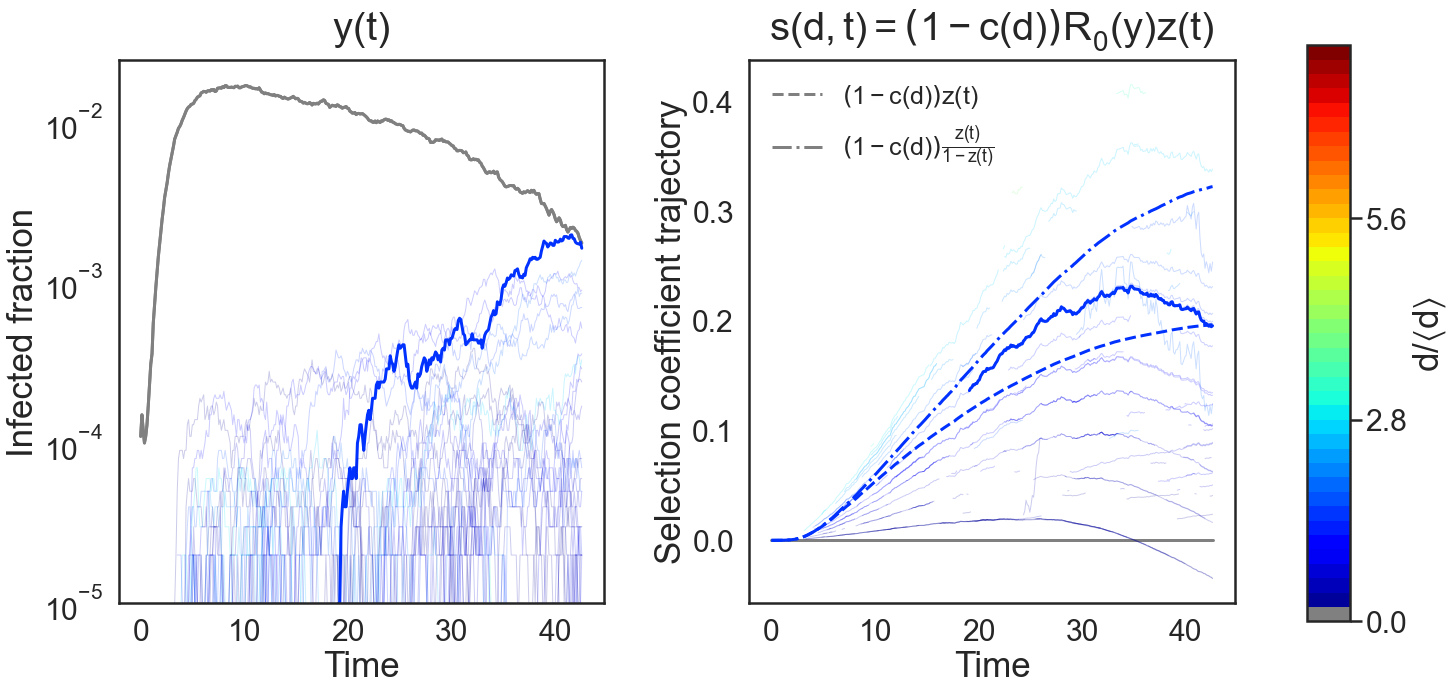

In [55]:

self = M_controlled

ds = np.arange(0,10 + np.round(np.log(mu*N)/p_alpha))
color_ds= dict(zip(ds,plt.cm.jet(np.linspace(0,1,len(ds)))))

fig,ax =plt.subplots(1,2,figsize=(20,10),sharex=True)
plt.subplots_adjust(hspace=.1,wspace=.3)
y0p = (R0-1-np.log(R0))/R0

xinf = self.find_x_inf(R0,kappa)
T = self.calc_T(R0,kappa,N)
zinf = 1-xinf
ts_det = np.linspace(0,T,1000)
x,y,z= odeint(model, np.array([1-10/N,10/N,0]), ts_det, args=(R0,kappa)).T


#get the three strains with the highest infected size
big_strains = sorted(self.strain_set, key=lambda x: x.recovered_size, reverse=True)[:5]
big_names=  [strain.name for strain in big_strains]

if True:
    ts_root= np.array(self.root_strain.times)
    I_root = np.array(self.root_strain.infected_history)
    S_root = np.array(self.root_strain.susceptible_history)
    R_root = np.array(self.root_strain.recovered_history)
    xparent = S_root/N
    zparent = R_root/N
    yparent = I_root/N
    t_peak = ts_root[np.argmax(I_root)]
    legend_ds = {}

for strain in self.strain_set:
    if strain.name==0:
        color='grey'
    else:
        color = color_ds[strain.distance_to_parent]

    I_i = np.array(strain.infected_history)
    if len(I_i)==0:
        continue

    c= np.exp(-strain.distance_to_parent/xi)
    s_inf = R0*(1-xinf)*(1-c)
    

    chi_i = np.array(strain.frequency_history)
    s_i = np.array(strain.selection_history)
    ts_i = np.array(strain.times)
    d_pc = strain.distance_to_parent
    
    if strain.root_intersection_time<np.inf or strain.name==0:
        
        # ax[1].axhline(s_inf,color=color,ls='--')
        t_i0 = ts_i[0]
        chi_0 = chi_i[0]
        if t_i0<t_peak:
            t_i0 = t_peak

            # ax[0].axvline(ts_i[np.argmin(np.abs(ts_i-t_peak))],color=color,ls='--')
        
        # ax[0].axhline(chi_0,color=color,ls='--')
        # ax[0].plot(ts_i, chi_0*np.exp(s_inf*(ts_i-t_i0)),color=color,ls=':')
        alpha= 1
        lw= 3
        # ax[1].plot(ts_root, R0/(1+ kappa*yparent)*(1-c)*zparent,color=color, alpha= alpha, lw = lw, linestyle=':')
        ax[1].plot(ts_root, (1-c)*zparent,color=color, alpha= alpha, lw = lw, linestyle='--')
        ax[1].plot(ts_root, (1-c)*zparent/(1-zparent),color=color, alpha= alpha, lw = lw, linestyle='-.')
        # ax[1].plot(ts)

    else: 
        alpha = .2
        lw= 1
    if strain.name ==0:
        ax[0].plot(ts_i[chi_i>0],I_i[chi_i>0]/N,color=color, alpha= alpha, lw = lw)
    ax[0].plot(ts_i[chi_i>0],I_i[chi_i>0]/N,color=color, alpha= alpha, lw = lw)
    ax[1].plot(ts_i,s_i ,color=color, alpha= alpha, lw = lw)    


for a in ax:
    a.set_xlabel('Time')
    
ax[0].set_title('$y(t)$',pad=20)
ax[0].set_ylabel('Infected fraction')
ax[0].set_yscale('log')
# ax[0].set_ylim((1/N,1))

ax[1].set_title(r'$s(d,t) = \left(1-c(d)\right) R_0 (y) z(t) $',pad=20)
ax[1].set_ylabel('Selection coefficient trajectory')

approx_handles = [mpl.lines.Line2D([0], [0], color='grey', lw=3, linestyle='--'), mpl.lines.Line2D([0], [0], color='grey', lw=3, linestyle='-.')]
approx_labels = [r'$\left(1-c(d)\right) z(t)$',r'$\left(1-c(d)\right) \frac{z(t)}{1-z(t)}$']

ax[1].legend(handles=approx_handles,labels=approx_labels,loc='best',frameon=False)
ax[0].set_ylim(bottom=1/N)
cmap = plt.cm.jet  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist[0] = (.5, .5, .5, 1.0)
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = ds*p_alpha
norm = mpl.colors.BoundaryNorm(ds*p_alpha, cmap.N)
ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                cax=ax2, orientation='vertical', label=r'$d/\langle d \rangle$', ticks=bounds[::14], boundaries=bounds[::14],format=FuncFormatter(fmt))#, format='%1f')


In [56]:
def plot_strain(strain, ax_n, ax_sel, color_ds, xi, R0, xinf, t_peak, N):
    if strain.name==0:
        color='grey'
    else:
        color = color_ds[strain.distance_to_parent]

    I_i = np.array(strain.infected_history)
    if len(I_i)==0:
        return 0
    d_pc = strain.distance_to_parent
    c= np.exp(-d_pc/xi)
    s_inf = R0*(1-xinf)*(1-c)
    

    chi_i = np.array(strain.frequency_history)
    s_i = np.array(strain.selection_history)
    ts_i = np.array(strain.times)
    
    
    if strain.root_intersection_time<np.inf or strain.name==0:
        
        t_i0 = ts_i[0]
        chi_0 = chi_i[0]
        if t_i0<t_peak:
            t_i0 = t_peak

        alpha= 1
        lw= 3

    else: 
        alpha = .2
        lw= 1
    if strain.name ==0:
        ax_n.plot(ts_i[chi_i>0],I_i[chi_i>0]/N,color=color, alpha= alpha, lw = lw)
    ax_sel.plot(ts_i[chi_i>0],I_i[chi_i>0]/N,color=color, alpha= alpha, lw = lw)
    ax_sel.plot(ts_i,s_i ,color=color, alpha= alpha, lw = lw)

In [57]:
M_uncontrolled = eqModel(N=N, infection_rate=beta, kappa= 0, recovery_rate=1, mutation_rate = mu, p_alpha= p_alpha,xi = xi, initial_infected=10,dt=None, figures_folder= figures_folder)
M_uncontrolled.run_to_extinction()
print('done')

  9%|▉         | 208/2372 [00:00<00:02, 874.38it/s] 

 48%|████▊     | 1140/2372 [06:01<06:30,  3.16it/s]  

done


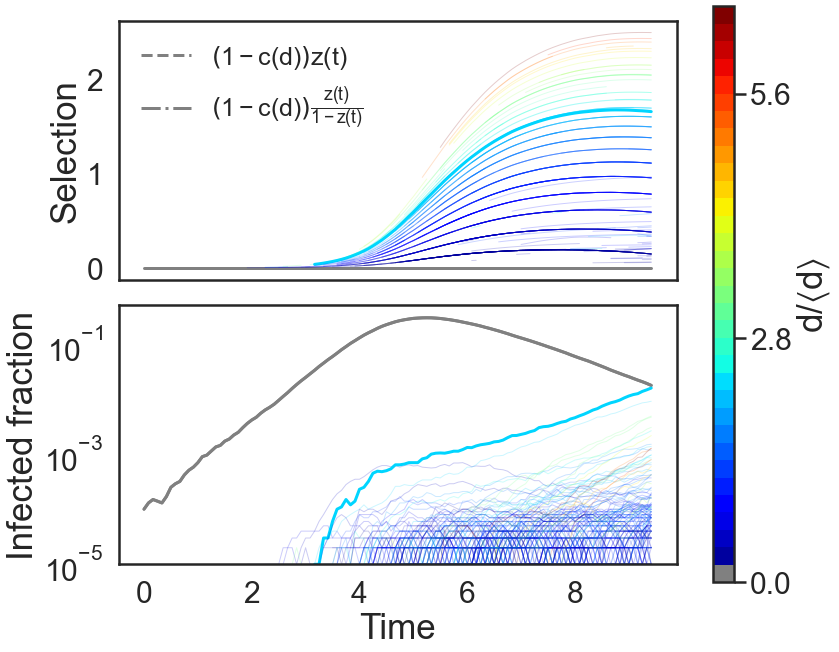

In [58]:

self = M_uncontrolled

dmax_controlled = np.max([strain.distance_to_parent for strain in M_controlled.strain_set])
dmax_uncontrolled = np.max([strain.distance_to_parent for strain in M_uncontrolled.strain_set])

ds = np.arange(0,np.max((dmax_controlled,dmax_uncontrolled))+1)
color_ds= dict(zip(ds,plt.cm.jet(np.linspace(0,1,len(ds)))))

fig,ax =plt.subplots(2,1,figsize=(10,10),sharex=True)
ax = ax[::-1]
plt.subplots_adjust(hspace=.1,wspace=.3)
y0p = (R0-1-np.log(R0))/R0

xinf = self.find_x_inf(R0,kappa)
T = self.calc_T(R0,kappa,N)
zinf = 1-xinf
ts_det = np.linspace(0,T,1000)
x,y,z= odeint(model, np.array([1-10/N,10/N,0]), ts_det, args=(R0,kappa)).T


#get the three strains with the highest infected size
big_strains = sorted(self.strain_set, key=lambda x: x.recovered_size, reverse=True)[:5]
big_names=  [strain.name for strain in big_strains]

if True:
    ts_root= np.array(self.root_strain.times)
    I_root = np.array(self.root_strain.infected_history)
    S_root = np.array(self.root_strain.susceptible_history)
    R_root = np.array(self.root_strain.recovered_history)
    xparent = S_root/N
    zparent = R_root/N
    yparent = I_root/N
    t_peak = ts_root[np.argmax(I_root)]
    legend_ds = {}

for strain in self.strain_set:
    if strain.name==0:
        color='grey'
    else:
        color = color_ds[strain.distance_to_parent]

    I_i = np.array(strain.infected_history)
    if len(I_i)==0:
        continue

    c= np.exp(-strain.distance_to_parent/xi)
    s_inf = R0*(1-xinf)*(1-c)
    

    chi_i = np.array(strain.frequency_history)
    s_i = np.array(strain.selection_history)
    ts_i = np.array(strain.times)
    d_pc = strain.distance_to_parent
    
    if strain.root_intersection_time<np.inf or strain.name==0:
        
        t_i0 = ts_i[0]
        chi_0 = chi_i[0]
        if t_i0<t_peak:
            t_i0 = t_peak

        alpha= 1
        lw= 3

    else: 
        alpha = .2
        lw= 1
    if strain.name ==0:
        ax[0].plot(ts_i[chi_i>0],I_i[chi_i>0]/N,color=color, alpha= alpha, lw = lw)
    ax[0].plot(ts_i[chi_i>0],I_i[chi_i>0]/N,color=color, alpha= alpha, lw = lw)
    ax[1].plot(ts_i,s_i ,color=color, alpha= alpha, lw = lw)    


ax[0].set_xlabel('Time')
    
ax[0].set_ylabel('Infected fraction')
ax[0].set_yscale('log')
ax[1].set_ylabel('Selection')

# approx_handles = [mpl.lines.Line2D([0], [0], color='grey', lw=3, linestyle='--'), mpl.lines.Line2D([0], [0], color='grey', lw=3, linestyle='-.')]
# approx_labels = [r'$\left(1-c(d)\right) z(t)$',r'$\left(1-c(d)\right) \frac{z(t)}{1-z(t)}$']

ax[1].legend(handles=approx_handles,labels=approx_labels,loc='best',frameon=False)
ax[0].set_ylim(bottom=1/N)
cmap = plt.cm.jet  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist[0] = (.5, .5, .5, 1.0)
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = ds*p_alpha
norm = mpl.colors.BoundaryNorm(ds*p_alpha, cmap.N)
ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                cax=ax2, orientation='vertical', label=r'$d/\langle d \rangle$', ticks=bounds[::14], boundaries=bounds[::14],format=FuncFormatter(fmt))#, format='%1f')


In [63]:
sns.set_style('ticks')

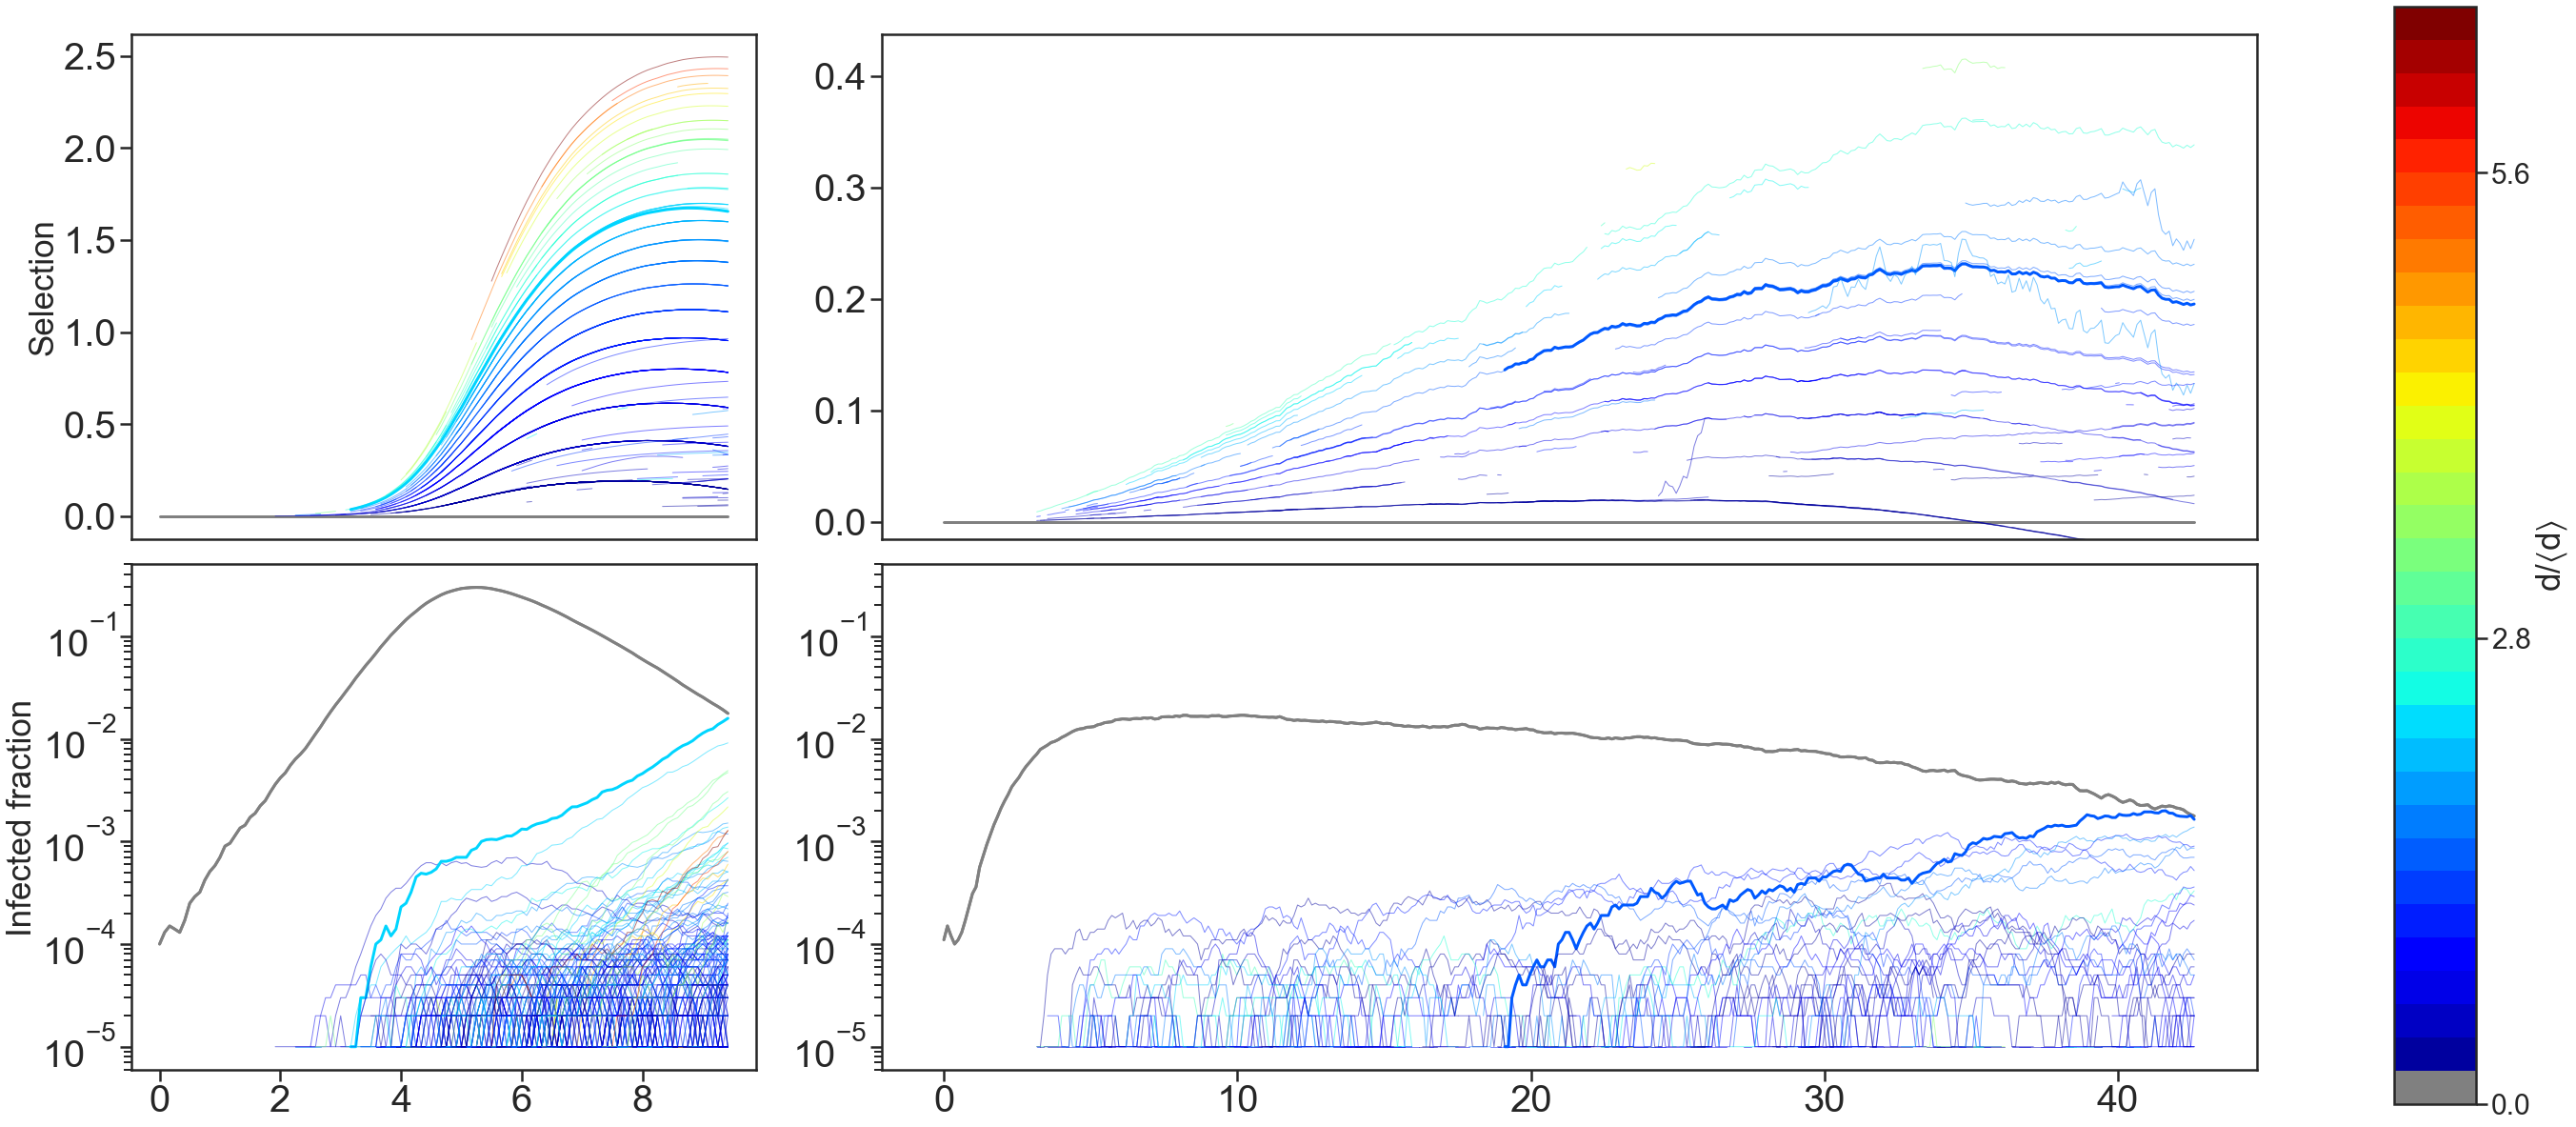

In [71]:
figure_mosaic ="""
AACCCC
BBDDDD
"""

dmax_controlled = np.max([strain.distance_to_parent for strain in M_controlled.strain_set])
dmax_uncontrolled = np.max([strain.distance_to_parent for strain in M_uncontrolled.strain_set])

ds = np.arange(0,np.max((dmax_controlled,dmax_uncontrolled))+1)
color_ds= dict(zip(ds,plt.cm.jet(np.linspace(0,1,len(ds)))))
# ax['A'].set_yticks([])

figsize= (40,20)

fig, ax = plt.subplot_mosaic(mosaic=figure_mosaic, figsize=figsize)
plt.subplots_adjust(wspace=.5,hspace=.05)

ts_root 

for strain in M_uncontrolled.strain_set:
    if strain.name==0:
        color='grey'
    else:
        color = color_ds[strain.distance_to_parent]

    I_i = np.array(strain.infected_history)
    if len(I_i)==0:
        continue

    c= np.exp(-strain.distance_to_parent/xi)
    s_inf = R0*(1-xinf)*(1-c)
    

    chi_i = np.array(strain.frequency_history)
    s_i = np.array(strain.selection_history)
    ts_i = np.array(strain.times)
    d_pc = strain.distance_to_parent
    
    if strain.root_intersection_time<np.inf or strain.name==0:

        t_i0 = ts_i[0]
        chi_0 = chi_i[0]
        if t_i0<t_peak:
            t_i0 = t_peak
        alpha= 1
        lw= 3

    else: 
        alpha = .5
        lw= 1
    if strain.name ==0:
        ax['B'].plot(ts_i[chi_i>0],I_i[chi_i>0]/N,color=color, alpha= alpha, lw = lw)
    ax['B'].plot(ts_i[chi_i>0],I_i[chi_i>0]/N,color=color, alpha= alpha, lw = lw)
    ax['A'].plot(ts_i,s_i ,color=color, alpha= alpha, lw = lw)    
ax['B'].set_yscale('log')

for strain in M_controlled.strain_set:
    if strain.name==0:
        color='grey'
    else:
        color = color_ds[strain.distance_to_parent]

    I_i = np.array(strain.infected_history)
    if len(I_i)==0:
        continue

    c= np.exp(-strain.distance_to_parent/xi)
    s_inf = R0*(1-xinf)*(1-c)
    

    chi_i = np.array(strain.frequency_history)
    s_i = np.array(strain.selection_history)
    ts_i = np.array(strain.times)
    d_pc = strain.distance_to_parent
    
    if strain.root_intersection_time<np.inf or strain.name==0:

        t_i0 = ts_i[0]
        chi_0 = chi_i[0]
        if t_i0<t_peak:
            t_i0 = t_peak
        alpha= 1
        lw= 3

    else: 
        alpha = .5
        lw= 1
    if strain.name ==0:
        ax['D'].plot(ts_i[chi_i>0],I_i[chi_i>0]/N,color=color, alpha= alpha, lw = lw)
    ax['D'].plot(ts_i[chi_i>0],I_i[chi_i>0]/N,color=color, alpha= alpha, lw = lw)
    ax['C'].plot(ts_i,s_i ,color=color, alpha= alpha, lw = lw)    
ax['D'].set_yscale('log')

ax['A'].set_xticks([])
ax['C'].set_xticks([])

ax['D'].set_ylim(ax['B'].get_ylim())
ax['A'].set_ylabel('Selection')
ax['B'].set_ylabel('Infected fraction')
cmap = plt.cm.jet  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist[0] = (.5, .5, .5, 1.0)
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = ds*p_alpha
norm = mpl.colors.BoundaryNorm(ds*p_alpha, cmap.N)
ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                cax=ax2, orientation='vertical', label=r'$d/\langle d \rangle$', ticks=bounds[::14], boundaries=bounds[::14],format=FuncFormatter(fmt))#, format='%1f')

ax['C'].set_ylim(bottom = ax['A'].get_ylim()[0]/8)
for a in ax.values():
    for tick in a.xaxis.get_major_ticks():
        tick.label.set_fontsize(40) 
    for tick in a.yaxis.get_major_ticks():
        tick.label.set_fontsize(40)

plt.savefig(output_folder+'fig_1.svg',bbox_inches='tight')

In [62]:
R0

3